In [1]:
import os
import re
import pickle
from dotenv import load_dotenv
from tqdm import tqdm
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from tester import Tester

In [2]:
BASE_MODEL = "meta-llama/Llama-3.2-1B"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

In [3]:
load_dotenv()
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [4]:
login(os.environ['HF_TOKEN'], add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [5]:
with open('./../data/app_train_dataset.pkl', 'rb') as f:
    train = pickle.load(f)
with open('./../data/app_test_dataset.pkl', 'rb') as f:
    test = pickle.load(f)

In [6]:
quant_config = BitsAndBytesConfig(load_in_4bit=True,
                                  bnb_4bit_use_double_quant=True,
                                  bnb_4bit_compute_dtype=torch.bfloat16,
                                  bnb_4bit_quant_type="nf4")

In [7]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL,
                                                  quantization_config=quant_config,
                                                  device_map='auto')
base_model.generation_config.pad_token_id = tokenizer.pad_token_id
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Memory footprint: 1.0 GB


In [8]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [9]:
extract_price("Price is $999 blah blah so cheap")

999.0

In [10]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [11]:
model_predict(test[0]['text'])

7.99

1: Guess: $7.99 Truth: $26.97 Error: $18.98 SLE: 1.29 Item: Discount Parts Direc...
2: Guess: $19.99 Truth: $36.99 Error: $17.00 SLE: 0.35 Item: BestRec Dryer Vent H...
3: Guess: $25.99 Truth: $41.33 Error: $15.34 SLE: 0.20 Item: Fuxury 12 Inch Impul...
4: Guess: $7.99 Truth: $45.02 Error: $37.03 SLE: 2.67 Item: Compatible Dryer Hea...
5: Guess: $7.99 Truth: $13.97 Error: $5.98 SLE: 0.26 Item: 694089 Dryer Blower ...
6: Guess: $1.99 Truth: $55.65 Error: $53.66 SLE: 8.65 Item: Compatible with Whir...
7: Guess: $6.40 Truth: $20.99 Error: $14.59 SLE: 1.19 Item: Replacement Aluminum...
8: Guess: $19.99 Truth: $30.68 Error: $10.69 SLE: 0.17 Item: Lifetime Appliance P...
9: Guess: $19.99 Truth: $57.99 Error: $38.00 SLE: 1.07 Item: OEM LG Refrigerator ...
10: Guess: $7.99 Truth: $8.99 Error: $1.00 SLE: 0.01 Item: Dryer Lint Filter Re...
11: Guess: $7.99 Truth: $25.95 Error: $17.96 SLE: 1.21 Item: FAMCO Dryer Vent Cov...
12: Guess: $7.99 Truth: $13.99 Error: $6.00 SLE: 0.26 Item: HIFROM Humidi

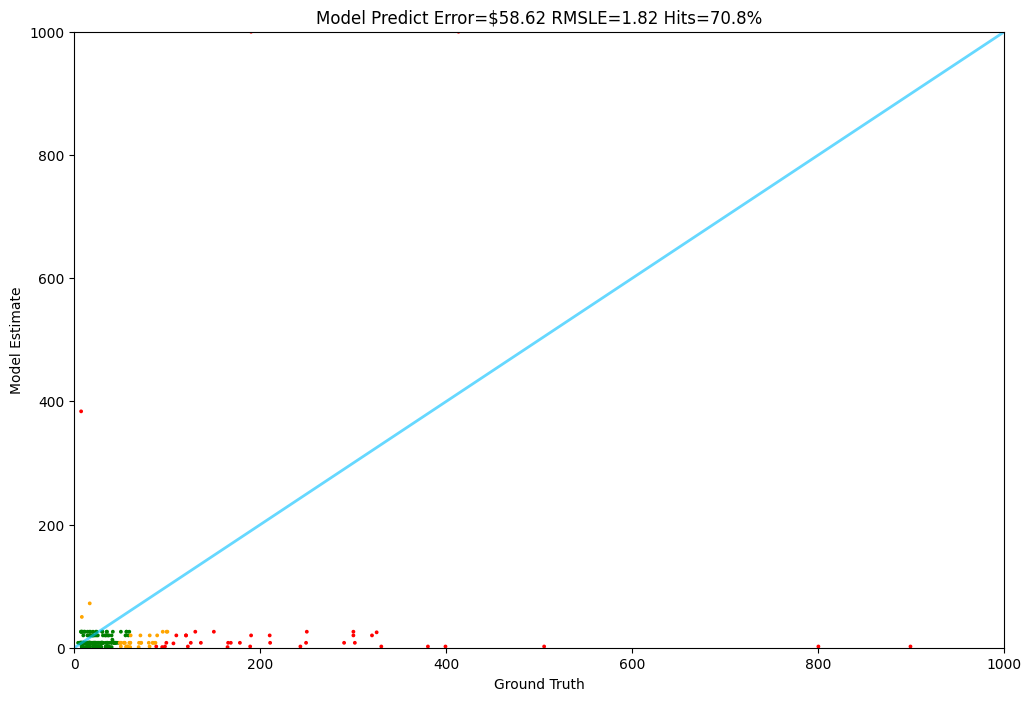

In [12]:
Tester.test(model_predict, test)